In [19]:
# === IMPORTS ===

REP_DIR = "/home/graffc/extra/fire_prediction/"
SRC_DIR = REP_DIR + 'src/'
DATA_DIR = REP_DIR + 'data/'

# --- System imports
import numpy as np
import os as os
import datetime as dt
from collections import defaultdict
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

# --- Package imports
import evaluation.evaluate_model as evm
import helper.loaders as load
import helper.multidata_wrapper as mdw
import visualization.plotting as vplt
import helper.date_util as du
import visualization.mapping as vmap
import evaluation.metrics as metrics

from models import grid_predictor as gp
from models import poisson_regression as pr
from models import active_ignition_grid as aig
from models import poisson_regression_grid as prg
from models import linear_regression_grid as lrg
from models import poisson_regression_zero_inflated as pzip
from models import bias_grid as bg
from models import autoregressive_grid as ag

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
# Days to predict
T_K_MAX = 5
T_K_ARR = np.arange(1,T_K_MAX+1)

# Years to use
YEAR_START, YEAR_END = 2007, 2016
YEARS_ARR = np.arange(YEAR_START, YEAR_END+1)

# === DATA FILES ===
ignition_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_ignition_cube_modis_alaska_2007-2016.pkl')
detection_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_detection_cube_modis_alaska_2007-2016.pkl')
weather_proc_region_src = os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl')
        
# Build list of file names (based on t_k)
#integrated_cluster_df_fmt = 'processed/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_src_list = map(lambda k: (k, os.path.join(DATA_DIR, integrated_cluster_df_fmt % k)), T_K_ARR)

In [3]:
# === DATA LOADING ===
X_ignition_c, Y_detection_c = evm.setup_ignition_data(ignition_cube_src, detection_cube_src)
weather_proc_region = load.load_pickle(weather_proc_region_src)

X_active_df = {}
for t_k,f_src in integrated_cluster_df_src_list:
    X_active_df[t_k] = evm.setup_active_fire_data(f_src)
    
BOUNDING_BOX = weather_proc_region.bounding_box

In [4]:
# Non-grid baselines
def only_zero_model(covariates):
    model = aig.ActiveIgnitionGridModel(None, None)
    
    return model

def no_ignition_model_poisson(covariates):
    afm = gp.GridPredictorModel(pr.PoissonRegressionModel(covariates), BOUNDING_BOX)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def no_ignition_model_poisson_zip(covariates):
    afm = gp.GridPredictorModel(pzip.PoissonRegressionZeroInflatedModel(covariates), BOUNDING_BOX)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

In [5]:
# Grid baselines

def only_bias_grid_model(covariates):
    igm = bg.BiasGridModel()
    model = aig.ActiveIgnitionGridModel(None, igm)
    
    return model


def auto_grid_model(covariates):
    igm = ag.AutoregressiveGridModel()
    model = aig.ActiveIgnitionGridModel(None, igm)
    
    return model

In [23]:
# Grid models
def only_zero_grid_model(covariates):
    model = aig.ActiveIgnitionGridModel(None, None)
    
    return model

def no_ignition_grid_model_poisson(covariates):
    afm = prg.PoissonRegressionGridModel(covariates)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def active_only_grid_model_poisson(covariates):
    filter_func = lambda x: x[x.active]
    pred_func = lambda x, y: y * x.active
    
    afm = prg.PoissonRegressionGridModel(covariates, filter_func, pred_func)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def active_only_grid_model_linear(covariates, active='active', regularizer_weight=None):
    filter_func = lambda x: x[x[active]]
    pred_func = lambda x, y: y * x[active]
    
    afm = lrg.LinearRegressionGridModel(covariates, regularizer_weight, filter_func, pred_func)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def active_ig_grid_model_poisson(covariates):
    filter_func = lambda x: x[x.active]
    pred_func = lambda x, y: y * x.active
    
    afm = prg.PoissonRegressionGridModel(covariates, filter_func, pred_func)
    
    filter_func = lambda x: x[x.active==False]
    pred_func = lambda x, y: y * (x.active==False)
    ifm = prg.PoissonRegressionGridModel(covariates, filter_func, pred_func)
    
    model = aig.ActiveIgnitionGridModel(afm, ifm)
    
    return model

In [7]:
def print_results_table(results_list):
    metrics_ = [metrics.mean_absolute_error, metrics.root_mean_squared_error]
    for results,title in results_list:
        print title
        print '====================='
        for metric in metrics_:
            print metric.__name__
            table = []
            for k,v in results.iteritems():
                vals = map(lambda x: round(metric(*flat(x)),5), results[k])
                table.append([k]+vals)
            print tabulate.tabulate(table)

In [8]:
def build_y(y, t_k_arr, years=None):
    y_dict = {}
    for t_k in t_k_arr:
        # Shift y by t_k days
        shape = np.shape(y.values)[:2]+(t_k,)
        y_new = np.concatenate((y.values, np.zeros(shape)), axis=2)
        y_new = y_new[:,:,t_k:]
        
        # Convert y_new to an xarray dataset
        y_ds = xr.DataArray(y_new, coords={'time': pd.to_datetime(y.dates)}, dims=('y', 'x', 'time'))
        
        if years:
            y_ds = y_ds.sel(time=np.isin(y_ds.time.dt.year, years))
        
        y_dict[t_k] = y_ds
        
    return y_dict

def build_x_active(X, t_k_arr, years=None):
    X_dict = {}
    for t_k in t_k_arr:
        dates = pd.to_datetime(np.array(X[t_k]['date_local']))
        X_ds = xr.Dataset({'num_det': (('time'), X[t_k]['num_det']),
                           'temperature': (('time'), X[t_k]['temperature']),
                           'humidity': (('time'), X[t_k]['humidity']),
                           'wind': (('time'), X[t_k]['wind']),
                           'rain': (('time'), X[t_k]['rain']),
                           'lat_centroid': (('time'), X[t_k]['lat_centroid']),
                           'lon_centroid': (('time'), X[t_k]['lon_centroid']),
                           'num_det_target': (('time'), X[t_k]['num_det_target'])},
                          {'time': dates})
        
        if years:
            X_ds = X_ds.sel(time=np.isin(X_ds.time.dt.year, years))
        
        X_dict[t_k] = mdw.MultidataWrapper((X_ds,None))
    return X_dict

In [9]:
fill_n_days = 5

def fill_missing_value(data, date_ind):                                                    
    """
    Try to replace with closest prev day in range [1, fill_n_days].                                                

    If no non-nan value is found, replaces with mean of all values at the given lat/lon.                           
    """ 
    for day_offset in range(1,fill_n_days+1):                                                                 
        new_date_ind = date_ind - day_offset                                                                       

        if new_date_ind < 0:                                                                                       
            break                                                                                                  

        val = data[:, :, new_date_ind]                                                                 

        if not np.any(np.isnan(val)):                                                                                      
            return val                                                                                             

    return np.nanmean(data[:, :, :], axis=2)

def get_date_index(weather_data, target_datetime):
        date_ind = np.searchsorted(weather_data.dates, target_datetime, side='left')

        # Check if left or right element is closer
        if date_ind != 0:
            date_ind_left, date_ind_curr = date_ind-1, date_ind

            dist_left = abs((weather_data.dates[date_ind_left] - target_datetime).total_seconds())
            dist_curr = abs((weather_data.dates[date_ind_curr] - target_datetime).total_seconds())
            
            if dist_left < dist_curr:
                date_ind = date_ind_left

        return date_ind
    
def get_weather_variables(vals,weather_data, target_datetime, covariates):                                                             
    # Get date index
    date_ind = get_date_index(weather_data, target_datetime)                                                  

    #vals = []
    for key in covariates:                                                                           
        data = weather_data[key].values                                                                            
        val = data[:, :, date_ind]                                                                 

        if np.any(np.isnan(val)):
            val = fill_missing_value(data, date_ind)                                        

        #vals.append(val)                                                                                           
        vals[key].append(val)    

In [10]:
def create_cell_encoding(group_size, shape):
    data = []
    
    num_rows = int(np.ceil(shape[0]/(1.*group_size)))
    num_cols = int(np.ceil(shape[1]/(1.*group_size)))

    enc_all = np.zeros((num_rows,num_cols,shape[0],shape[1],shape[2]))
    
    # fill enc for each cell
    for i in range(shape[0]):
        for j in range(shape[1]):
            enc_all[int(i/group_size),int(j/group_size),i,j,:]=1
    
    # split into columns
    for i in range(num_rows):
        for j in range(num_cols):
            enc = enc_all[i,j]
            data.append(('cell_%d_%d'%(i,j),enc))
    return data
    
def build_x_grid(X, y, t_k_arr, num_auto_memory=0, num_weather_mem=0, years=None):
    X_dict = {}
    for t_k in t_k_arr:
        
        # Shift y by t_k days
        shape = np.shape(y.values)[:2]+(t_k,)
        y_new = np.concatenate((y.values, np.zeros(shape)), axis=2)
        y_new = y_new[:,:,t_k:]
            
        # Build grid of weather
        vals = defaultdict(list)
        for date in Y_detection_c.dates:
            time = 14
            date += du.INC_ONE_DAY * t_k # For row t, store weather(t+k)
            target_datetime = dt.datetime.combine(date, dt.time(time, 0, 0, tzinfo=du.TrulyLocalTzInfo(153, du.round_to_nearest_quarter_hour)))
            
            get_weather_variables(vals, X, target_datetime, ['temperature','humidity','wind','rain'])

        for k,v in vals.iteritems():
            vals[k] = np.rollaxis(np.array(v), 0, 3)  
        
        dates = pd.to_datetime(np.array(y.dates))
        X_ds = xr.Dataset({'num_det': (('y','x','time'), y.values),
                           'num_det_target': (('y', 'x', 'time'), y_new),
                           'active': (('y', 'x', 'time'), y.values!=0),
                           'temperature': (('y','x','time'), vals['temperature']),
                           'humidity': (('y','x','time'), vals['humidity']),
                           'wind': (('y','x','time'), vals['wind']),
                           'rain': (('y','x','time'), vals['rain'])},
                          {'time': dates})
        
        # Add autoregressive memory
        for i in range(1,num_auto_memory+1):
            shape = np.shape(y.values)[:2]+(i,)
            y_mem = np.concatenate((np.zeros(shape), y.values), axis=2)
            y_mem = y_mem[:,:,:-i]
            
            # Add one and apply log
            y_mem = np.log(y_mem+1)
            
            name = 'num_det_' + str(i)
            X_ds.update({name: (('y','x','time'), y_mem)})
            
        # Add weather memory
        rain_mean = np.mean(vals['rain'])
        for i in range(1,num_weather_mem+1):
            shape = np.shape(y.values)[:2]+(i,)
            x_mem = np.concatenate((np.zeros(shape)+rain_mean, vals['rain']), axis=2)
            x_mem = x_mem[:,:,:-i]
            
            name = 'rain_' + str(i)
            X_ds.update({name: (('y','x','time'), x_mem)})
        
        if years:
            X_ds = X_ds.sel(time=np.isin(X_ds.time.dt.year, years))
                       
        X_dict[t_k] = mdw.MultidataWrapper((X_ds,X_ds))
        
        print 'T_k=%d' % t_k,
    print
    return X_dict

In [11]:
#YEARS_TRAIN = [2007,2008,2009]
#YEARS_TEST = [2007, 2008,2009]
YEARS_TRAIN = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
YEARS_TEST = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
T_K_ARR = np.arange(1,5+1)

y_grid_dict = build_y(Y_detection_c, T_K_ARR, YEARS_TRAIN)
X_active_dict = build_x_active(X_active_df, T_K_ARR, YEARS_TRAIN)
X_grid_dict = build_x_grid(weather_proc_region, Y_detection_c, T_K_ARR, 15, 15, YEARS_TRAIN)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [12]:
# Add encoding pairs (for cell/region biases)
encoding_pairs = create_cell_encoding(11, X_grid_dict[1][0].num_det.shape)
for k,v in X_grid_dict.iteritems():
    for name,enc in encoding_pairs:
        v[0].update({name: (('y','x','time'), enc)})

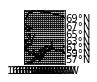

In [13]:
plt.rcParams['figure.figsize'] = [1, 1]
bb = weather_proc_region.bounding_box
mp = vmap.make_map(bb)

In [14]:
plt.rcParams['figure.figsize'] = [15, 15]
water_mask = np.zeros((33,55))
for i,lat in enumerate(np.arange(55, 71+.5, .5)):
    for j,lon in enumerate(np.arange(-165, -138+.5, .5)):
        water_mask[i,j] = not mp.is_land(*mp(lon,lat))
        
water_mask = np.expand_dims(water_mask, axis=2)    
water_mask = np.tile(water_mask, (1,1,X_grid_dict[1][0].time.shape[0]))
        
for k,v in X_grid_dict.iteritems():
    v[0].update({'water_mask': (('y','x','time'), water_mask)})

In [44]:
v[0]

<xarray.Dataset>
Dimensions:         (time: 1100, x: 55, y: 33)
Coordinates:
  * time            (time) datetime64[ns] 2007-05-14 2007-05-15 2007-05-16 ...
Dimensions without coordinates: x, y
Data variables:
    temperature     (y, x, time) float32 261.0 269.4 273.0 268.9 270.3 269.9 ...
    num_det         (y, x, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rain            (y, x, time) float64 0.0 0.0 1.002 1.002 0.0 0.0 0.0 0.0 ...
    humidity        (y, x, time) float32 90.0 96.0 86.0 91.0 89.0 87.0 93.0 ...
    active          (y, x, time) bool False False False False False False ...
    num_det_target  (y, x, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    wind            (y, x, time) float32 0.412311 3.1257 3.17805 3.08058 ...
    num_det_1       (y, x, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    num_det_2       (y, x, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    num_det_3       (y, x, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

In [40]:
param_dict = {'None': [],
              'Temp/Humid': ['temperature', 'humidity'],
              'All': ['temperature','humidity','wind','rain']}

param_dict_grid = {#'None': [],
              #'Temp/Humid': ['temperature', 'humidity'],
              #'All': ['temperature','humidity','wind','rain'],
              #'All + Water': ['temperature','humidity','wind','rain', 'water_mask'],
              #'All + Water (2)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,2)],
              #'All + Water (5)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,5)],
              #'All + Water (10)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,10)],
              #'All + Water (15)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,15)],
              'All + Water (2,2)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,2)] + ['rain_' + str(i) for i in range(1,2)],
              'All + Water (5,5)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,5)] + ['rain_' + str(i) for i in range(1,5)],     
              'All + Water (10,10)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,10)] + ['rain_' + str(i) for i in range(1,10)],
              'All + Water (15,15)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,15)] + ['rain_' + str(i) for i in range(1,15)],}
              #'All + Biases': [n for n in X_grid_dict[1][0].data_vars if n != 'num_det_target']}             

In [226]:
# Test baselines
reload(gp)
reload(pzip)
reload(pr)
results_only_zero, models_only_zero = evm.evaluate_model_params(only_zero_model, param_dict, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_no_ig, models_no_ig = evm.evaluate_model_params(no_ignition_model_poisson, param_dict, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
#results_no_ig_zip, models_no_ig_zip = evm.evaluate_model_params(no_ignition_model_poisson_zip, param_dict, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3
T_k=1 T_k=2 T_k=3


In [53]:
results_only_bias_grid, models_only_bias_grid = evm.evaluate_model_params(only_bias_grid_model, {'None': []}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [15]:
results_auto_grid, models_auto_grid = evm.evaluate_model_params(auto_grid_model, {'None': []}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [147]:
# Test grid models
results_only_zero_grid, models_only_zero_grid = evm.evaluate_model_params(only_zero_grid_model, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [228]:
reload(prg)
results_no_ig_grid, models_no_ig_grid = evm.evaluate_model_params(no_ignition_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [45]:
reload(prg)
results_active_only_grid, models_active_only_grid = evm.evaluate_model_params(active_only_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [24]:
results_active_only_grid_lin, models_active_only_grid_lin = evm.evaluate_model_params(active_only_grid_model_linear, {'All': ['temperature', 'humidity', 'wind', 'rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [ ]:
results_active_ig_grid, models_active_ig_grid = evm.evaluate_model_params(active_ig_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [17]:
metrics_ = [metrics.mean_absolute_error, metrics.root_mean_squared_error, metrics.neg_log_likelihood_poisson]
plt.rcParams['figure.figsize'] = [15, 15]

In [64]:
import pickle

def save(data, file_name):
    with open(file_name, 'wb') as fout:
        pickle.dump(data, fout)

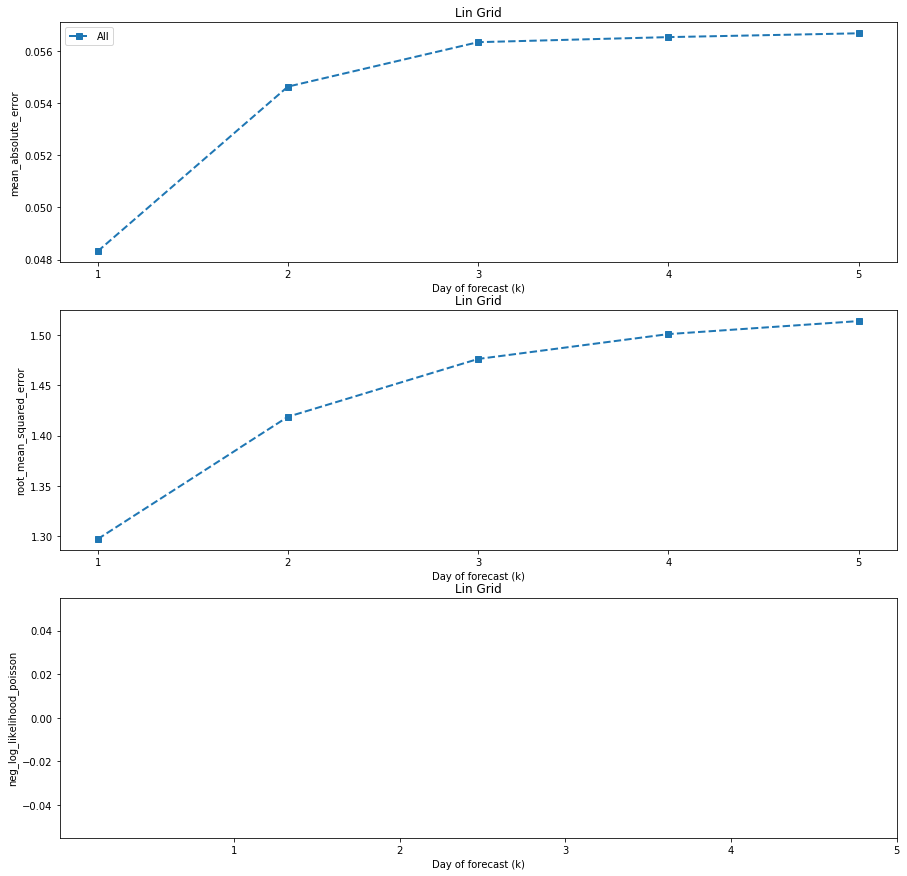

In [25]:
out = vplt.plot_results_grid([(results_active_only_grid_lin[1], 'Lin Grid') ], T_K_ARR, metrics_)

In [275]:
save(out, 'no-ig-g_and_active-only-g_out.pkl')

### No-Ignition (G) vs. Active-Only (G) (Out of sample)

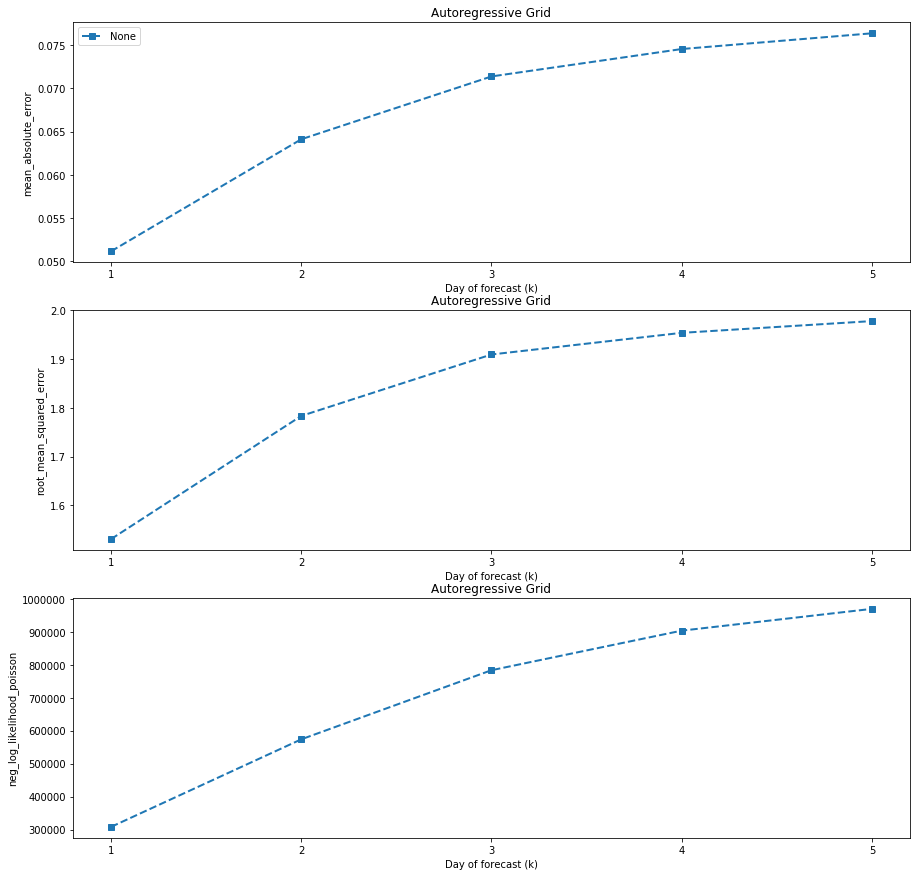

In [18]:
out = vplt.plot_results_grid([(results_auto_grid[1], 'Autoregressive Grid') ], T_K_ARR, metrics_)

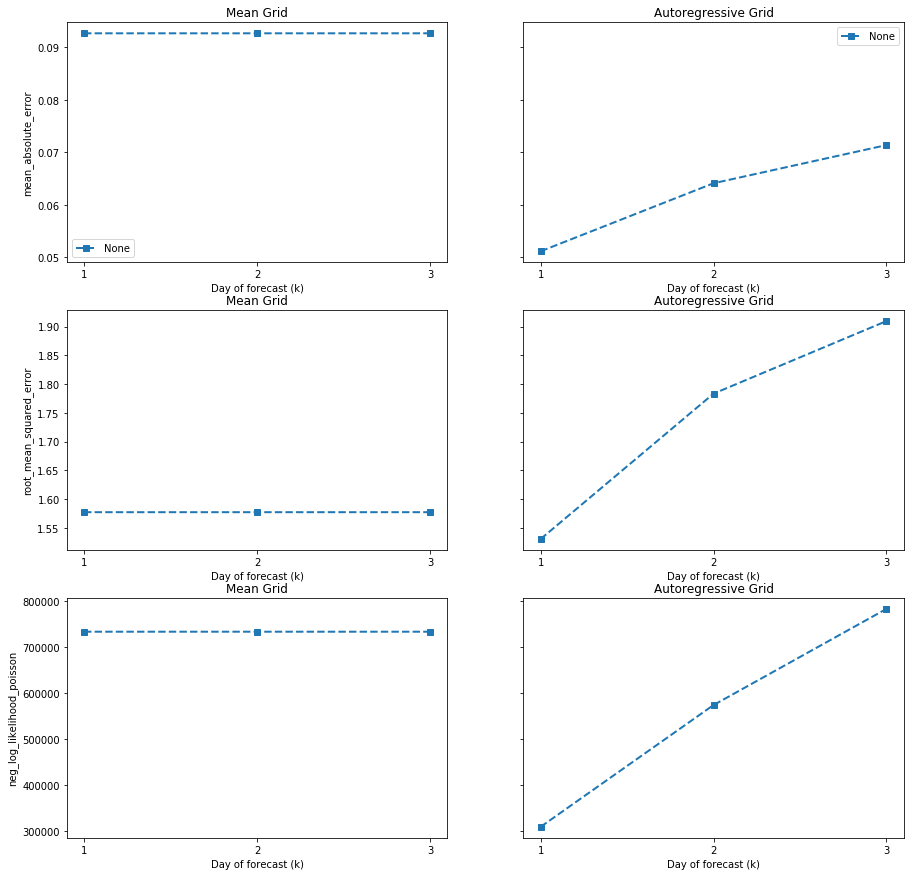

In [69]:
out = vplt.plot_results_grid([(results_only_bias_grid[1], 'Mean Grid'),(results_auto_grid[1], 'Autoregressive Grid') ], T_K_ARR, metrics_)
save(out, 'mean-only-g_and_auto-only-g_out.pkl')

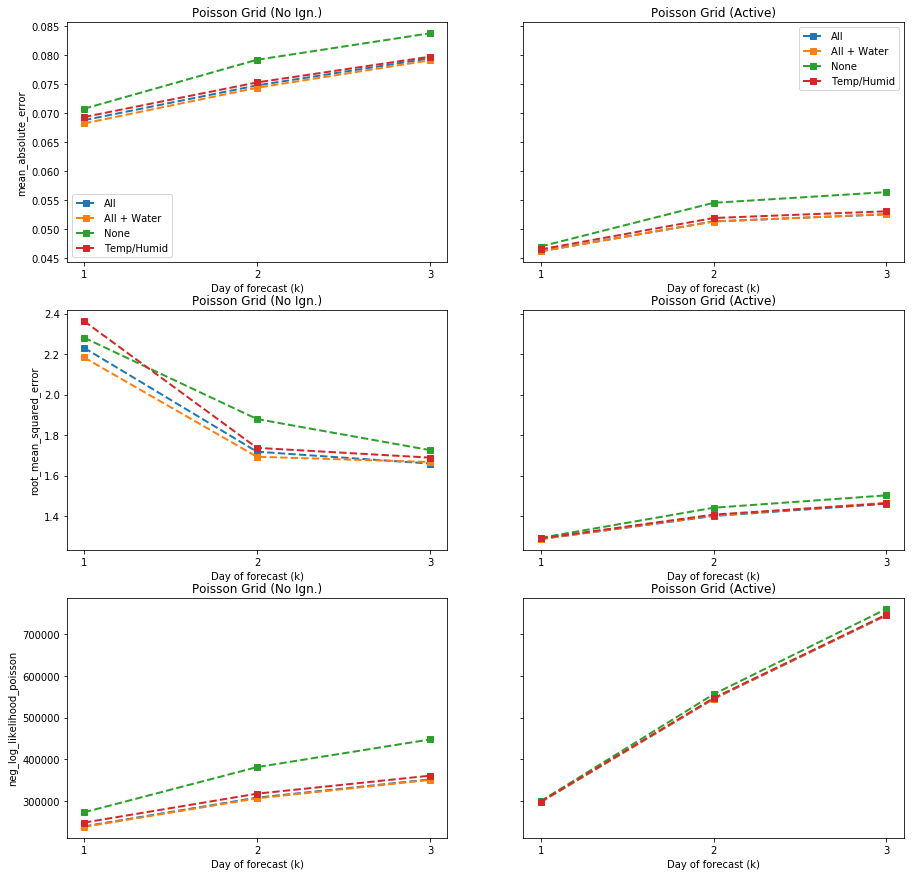

In [270]:
reload(vplt)
out = vplt.plot_results_grid([(results_no_ig_grid[1], 'Poisson Grid (Unified)'), (results_active_only_grid[1], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

### No-Ignition (G) vs. Active-Only (G) (In sample)

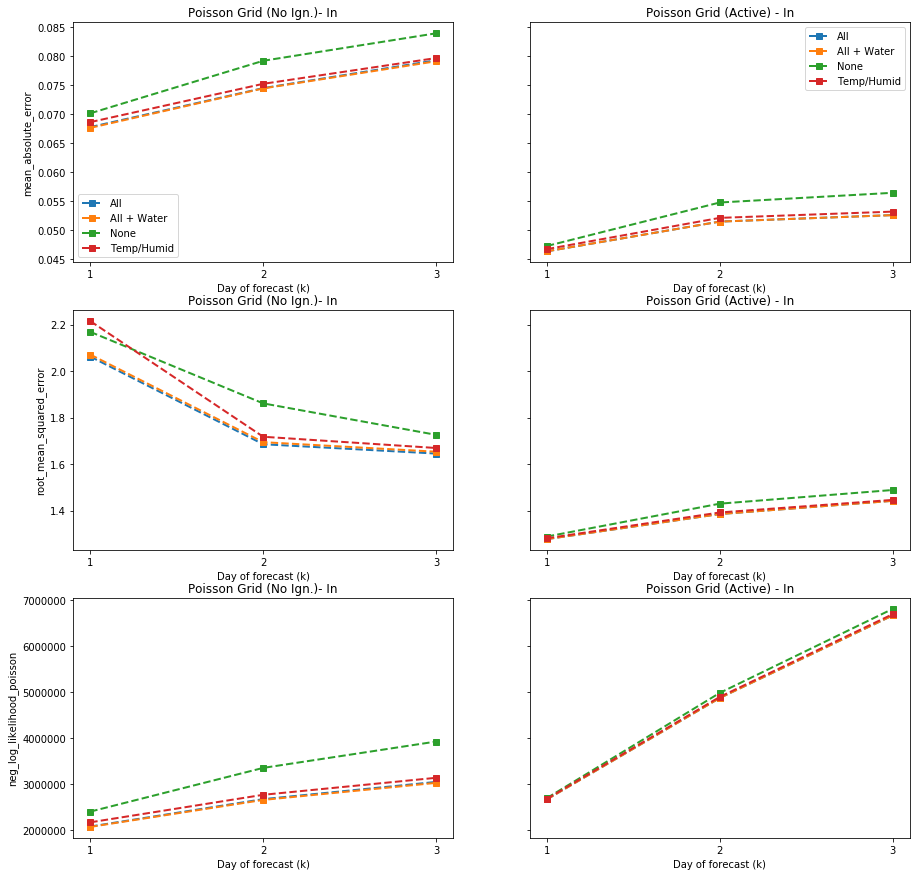

In [255]:
vplt.plot_results_grid([(results_no_ig_grid[0], 'Poisson Grid (No Ign.)- In'), (results_active_only_grid[0], 'Poisson Grid (Active) - In')], T_K_ARR, metrics_)

### Active-Ign. (G) vs. Active-Only (G) (Out of sample)

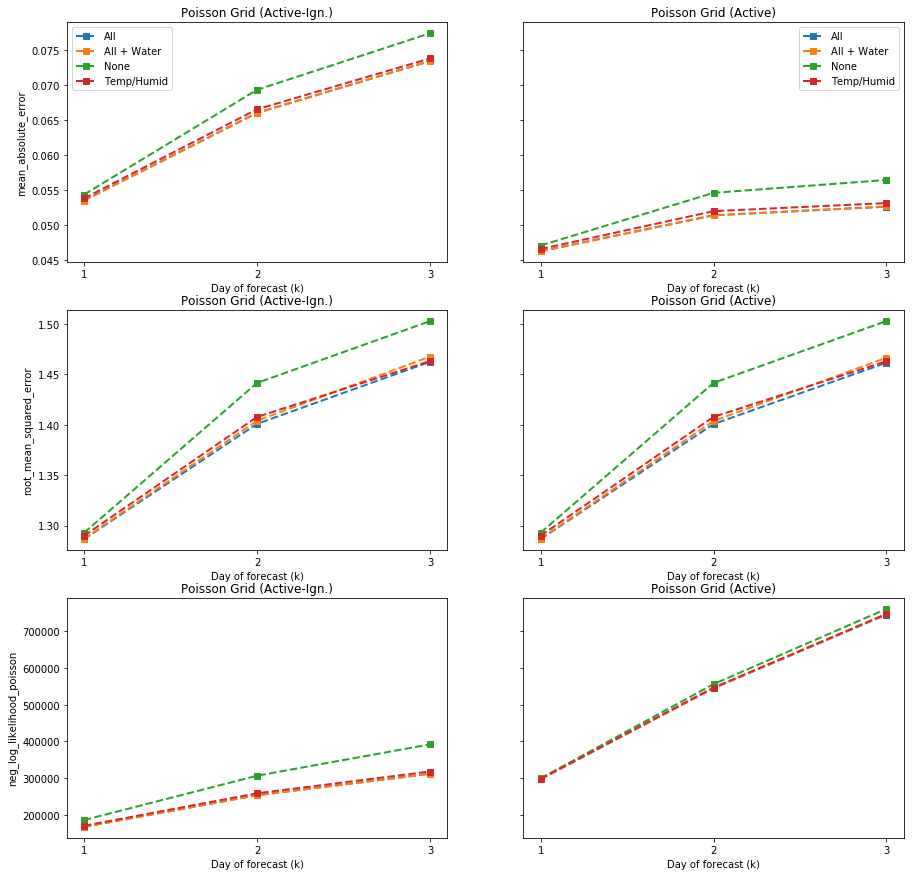

In [260]:
vplt.plot_results_grid([(results_active_ig_grid[1], 'Poisson Grid (Active-Ign.)'), (results_active_only_grid[1], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

### Active-Ign. (G) vs. Active-Only (G) (In sample)

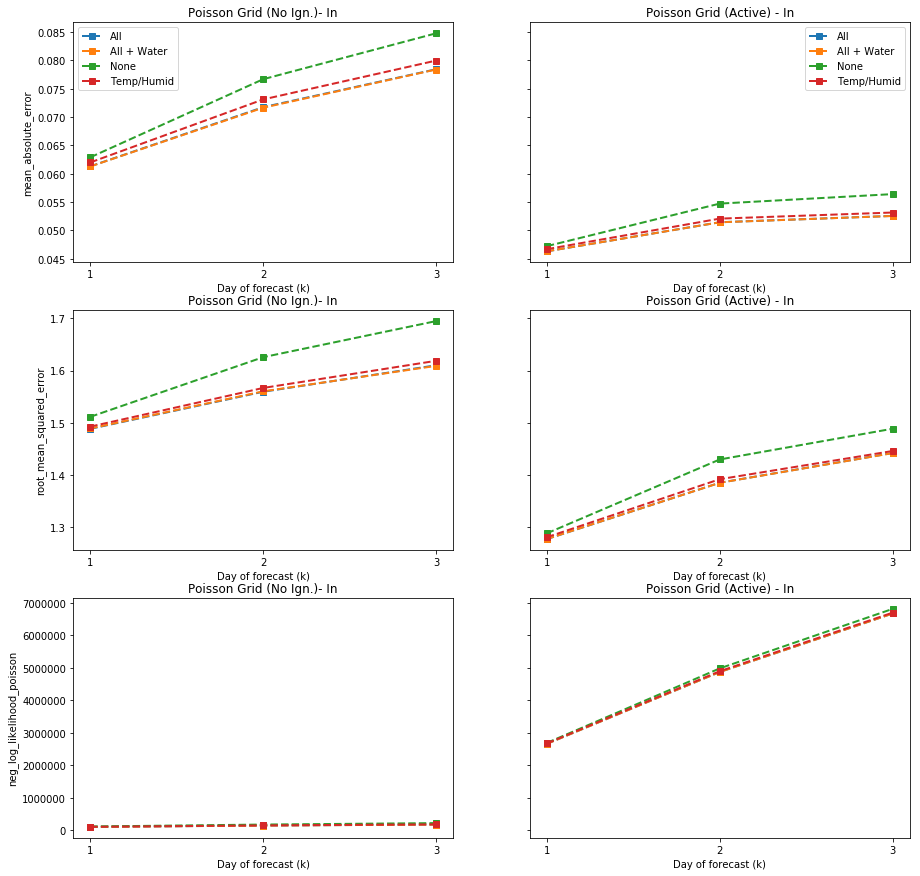

In [254]:
vplt.plot_results_grid([(results_active_ig_grid[0], 'Poisson Grid (Active-Ign.)- In'), (results_active_only_grid[0], 'Poisson Grid (Active) - In')], T_K_ARR, metrics_)

### Zero-Only vs. Active-Only (G) (Out of sample)

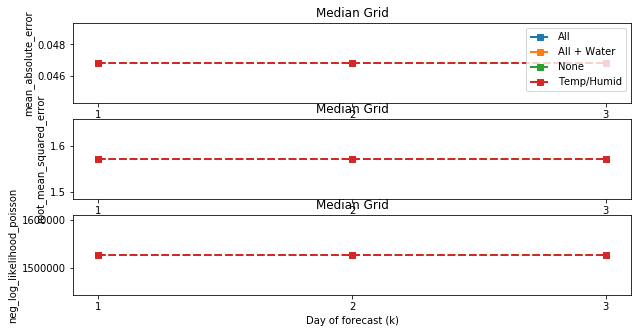

In [149]:
out = vplt.plot_results_grid([(results_only_zero_grid[1], 'Median Grid')], T_K_ARR, metrics_)

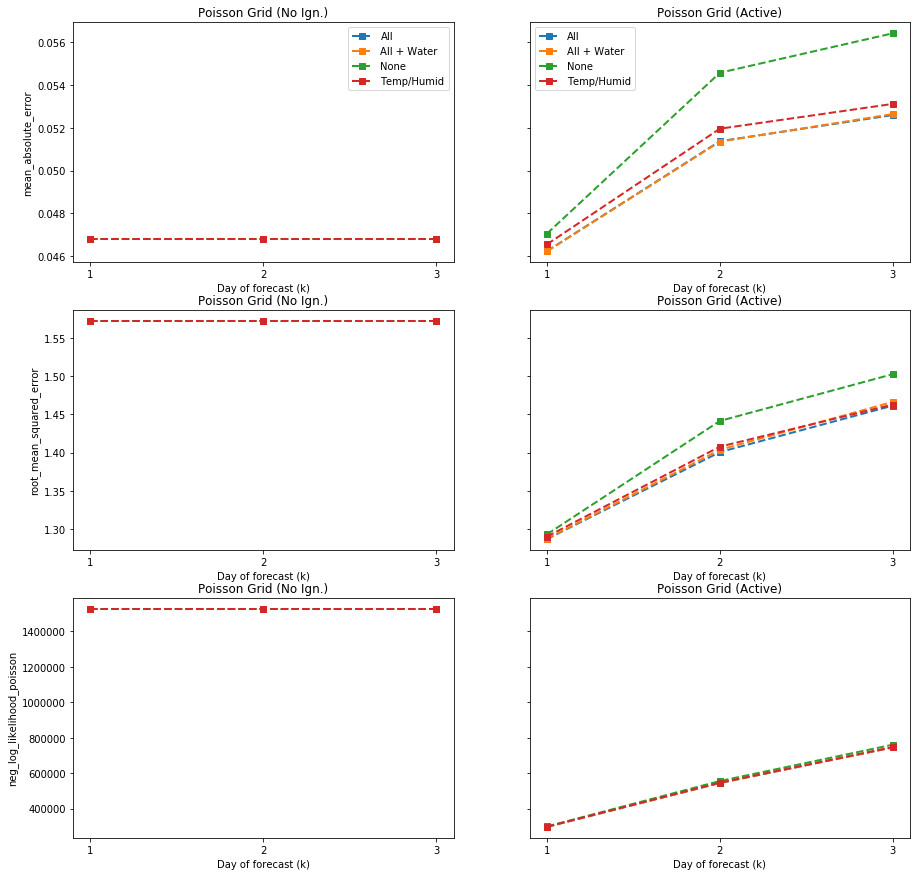

In [250]:
vplt.plot_results_grid([(results_only_zero_grid[1], 'Zero-Only'), (results_active_only_grid[1], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

### Zero-Only vs. Active-Only (G) (In sample)

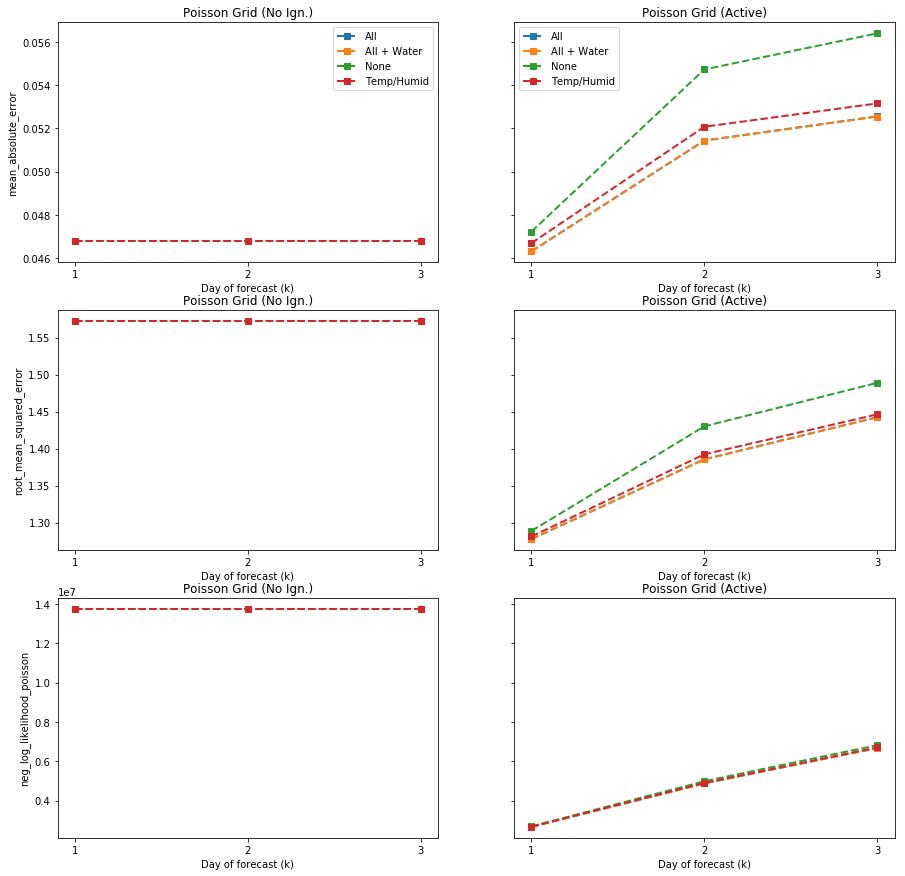

In [256]:
vplt.plot_results_grid([(results_only_zero_grid[0], 'Zero-Only'), (results_active_only_grid[0], 'Poisson Grid (Active) - In')], T_K_ARR, metrics_)

### Combined (Non-G) vs. Active-Only (G) (Out of sample)

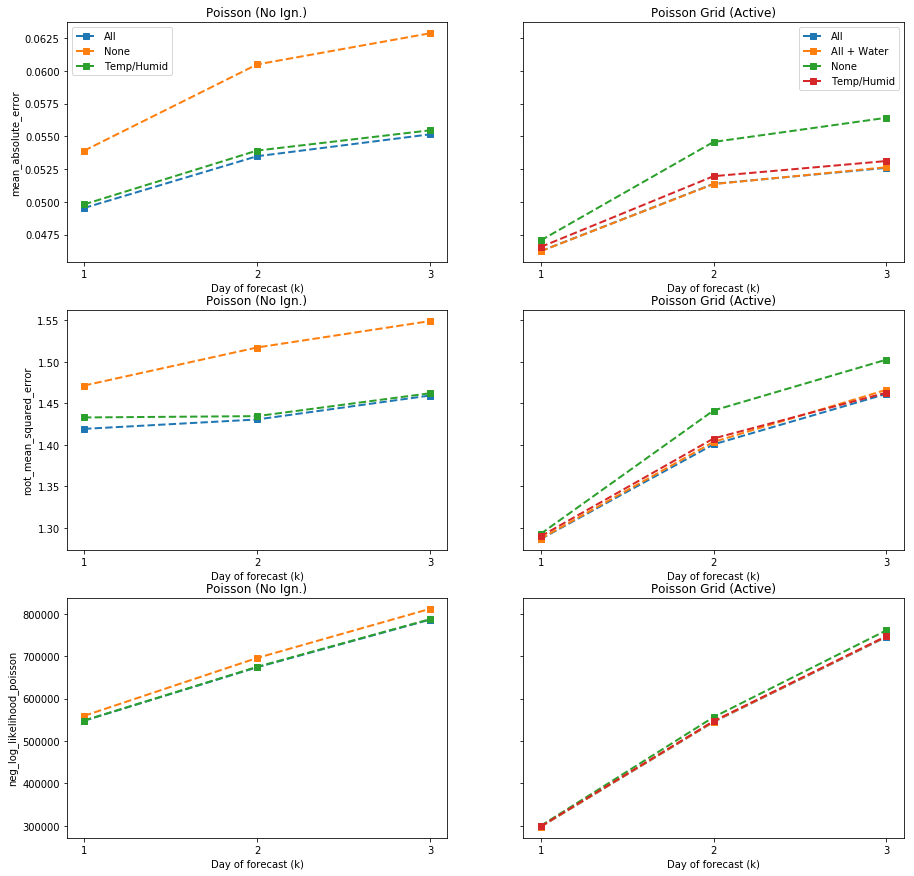

In [251]:
vplt.plot_results_grid([(results_no_ig[1], 'Poisson Non-Grid (No Ign.)'), (results_active_only_grid[1], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

### Combined (Non-G) vs. Active-Only (G) (In sample)

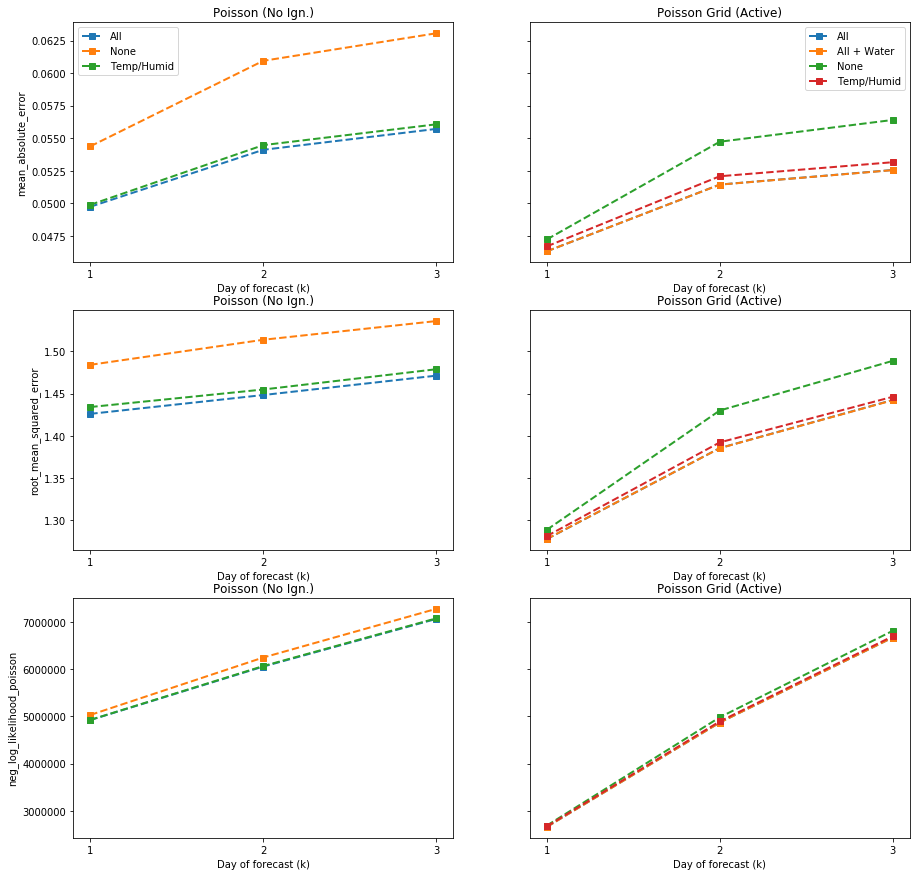

In [257]:
vplt.plot_results_grid([(results_no_ig[0], 'Poisson Non-Grid (No Ign.)'), (results_active_only_grid[0], 'Poisson Grid (Active) - In')], T_K_ARR, metrics_)

### Active-Only (Out of sample)

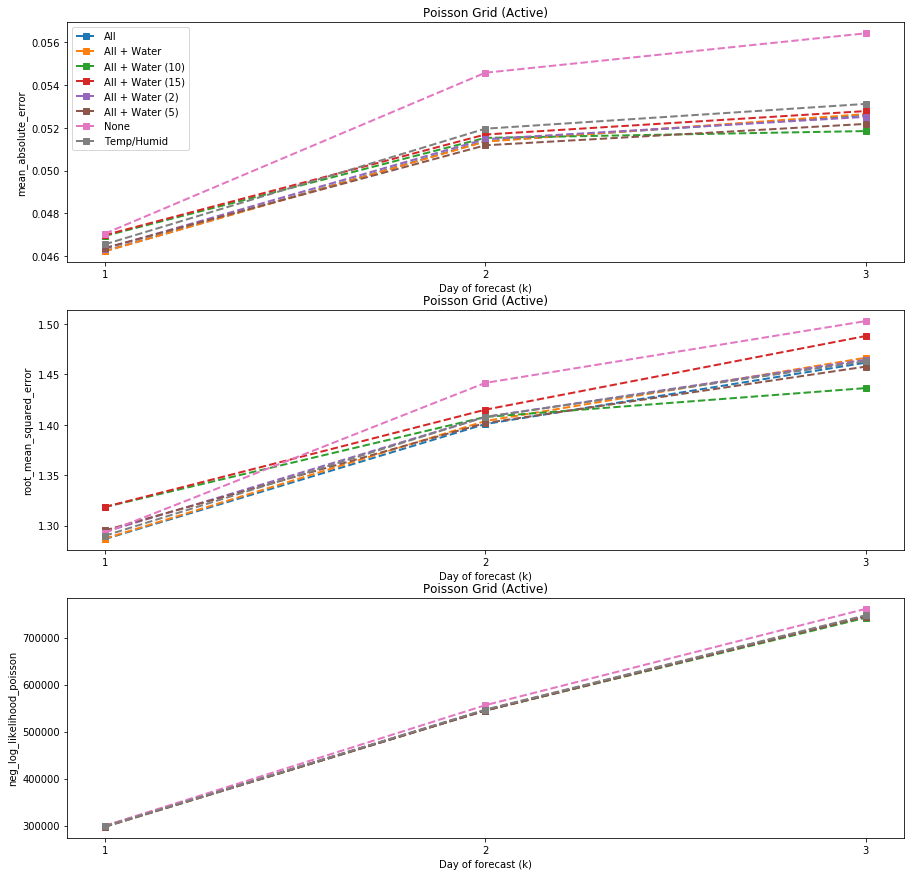

In [24]:
_ = vplt.plot_results_grid([(results_active_only_grid[1], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

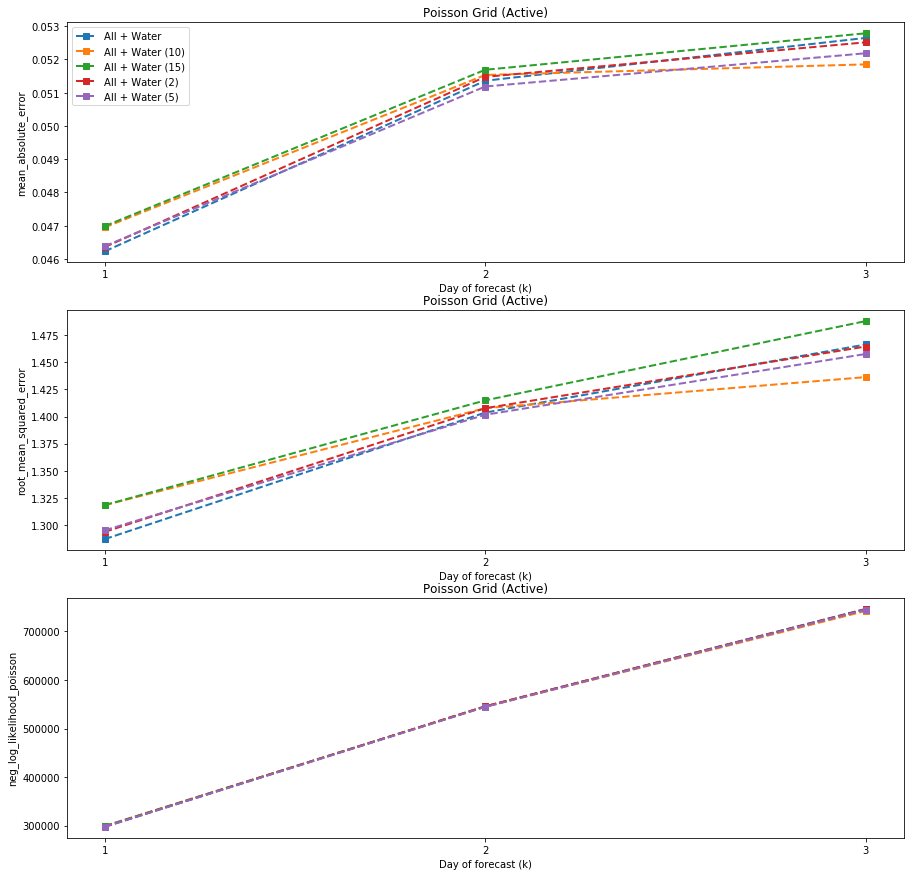

In [31]:
mem_only = {k: results_active_only_grid[1][k] for k in results_active_only_grid[1].keys() if 'All + Water' in k}
_ = vplt.plot_results_grid([(mem_only, 'Poisson Grid (Active)')], T_K_ARR, metrics_)

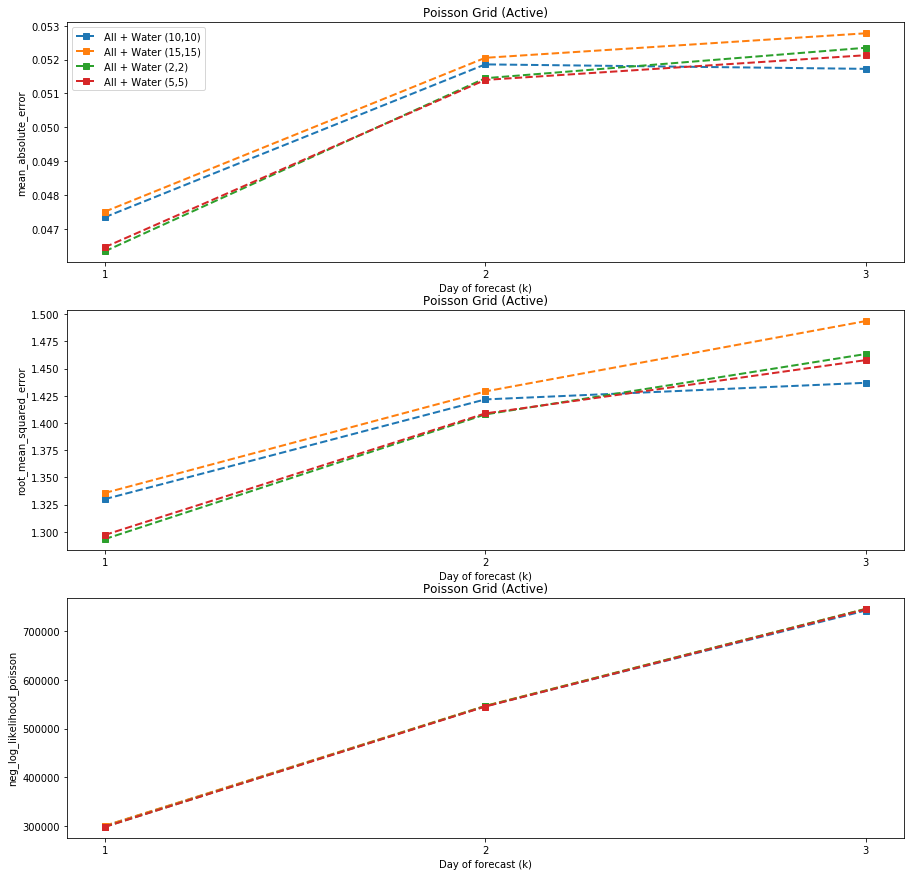

In [46]:
_ = vplt.plot_results_grid([(results_active_only_grid[1], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

### Active-Only (In sample)

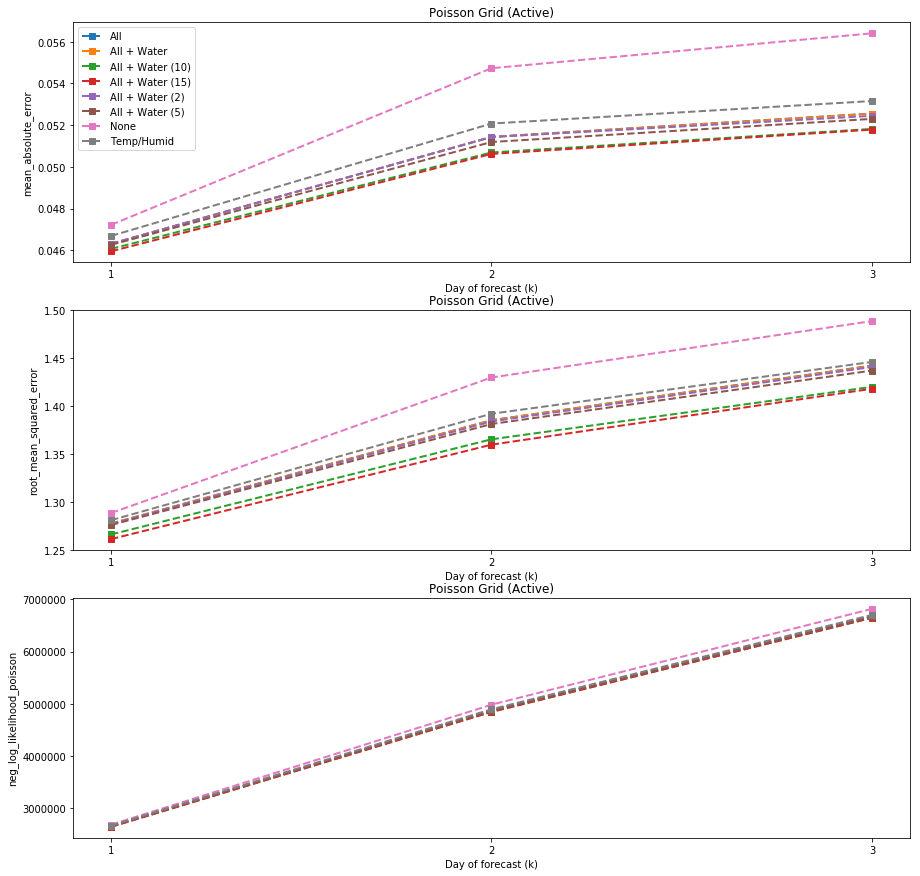

In [33]:
_ = vplt.plot_results_grid([(results_active_only_grid[0], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

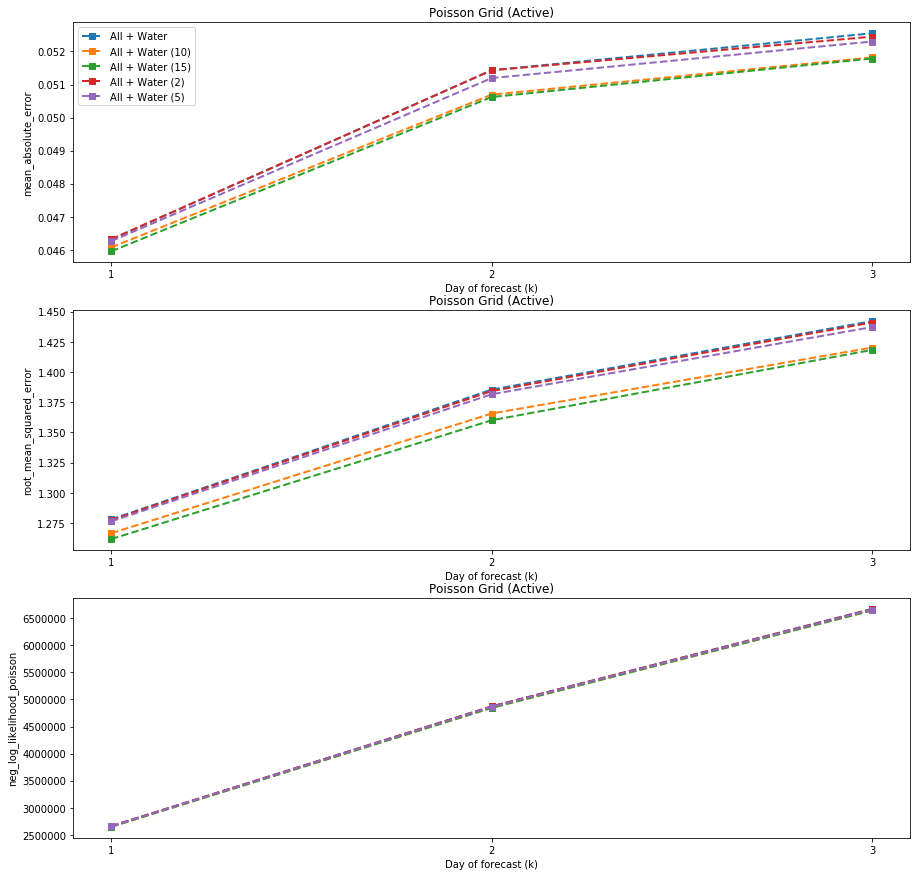

In [34]:
mem_only = {k: results_active_only_grid[0][k] for k in results_active_only_grid[0].keys() if 'All + Water' in k}
_ = vplt.plot_results_grid([(mem_only, 'Poisson Grid (Active)')], T_K_ARR, metrics_)

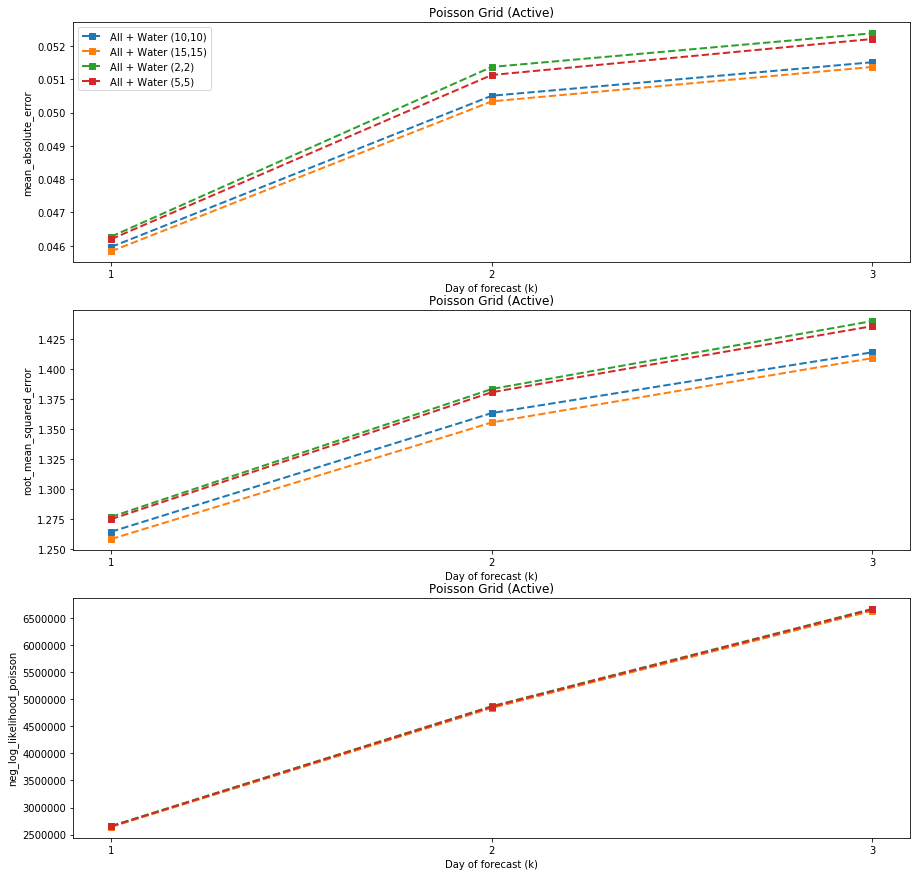

In [47]:
_ = vplt.plot_results_grid([(results_active_only_grid[0], 'Poisson Grid (Active)')], T_K_ARR, metrics_)

### Combined (Non-G) (Out of sample)

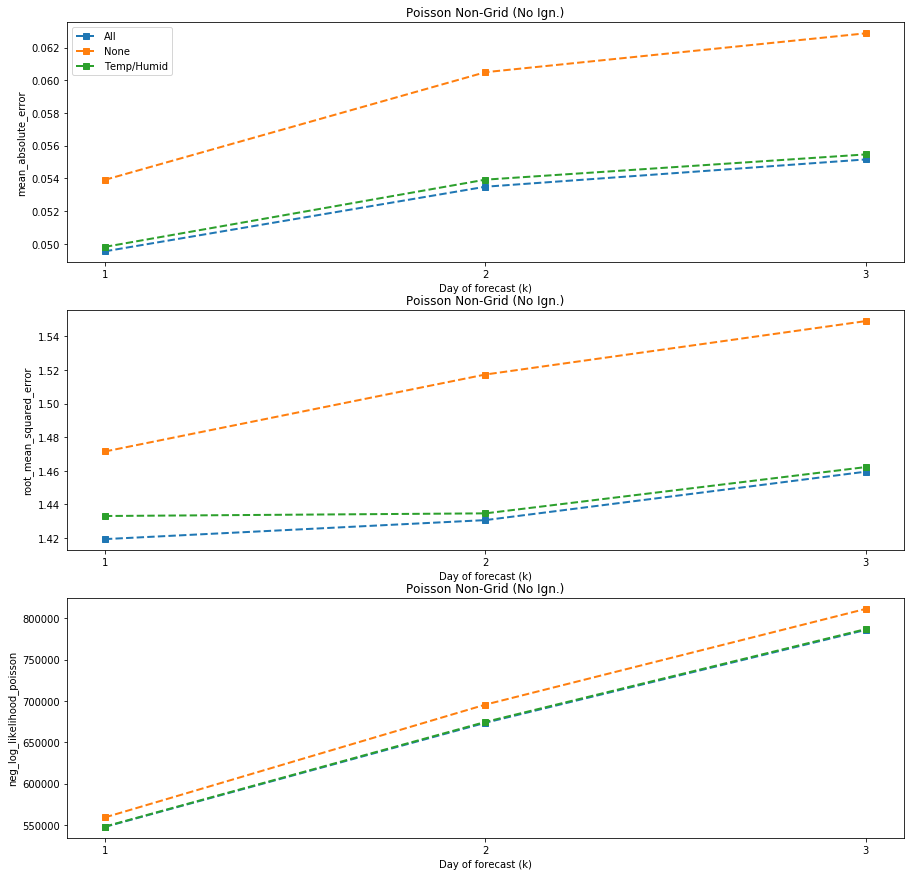

In [253]:
vplt.plot_results_grid([(results_no_ig[1], 'Poisson Non-Grid (No Ign.)')], T_K_ARR, metrics_)

### Combined (Non-G) (In sample)

In [ ]:
vplt.plot_results_grid([(results_no_ig[0], 'Poisson Non-Grid (No Ign.) - In')], T_K_ARR, metrics_)

In [ ]:
results_active_ig_grid

In [ ]:
out = vplt.plot_results_grid([(results_active_ig_grid[1], 'Poisson Grid (Active-Ign.)- Out')], T_K_ARR, metrics_)
save(out, 'active-ig-g_out.pkl')

In [177]:
def generate(shape):
    x = np.random.randn(shape[0], shape[1], shape[2])*5 + 12
    y = np.zeros(shape)
       
    for i in xrange(shape[0]):
        for j in xrange(shape[1]):
            y[i,j,0] = 1
            years = [Y_detection_c.dates[0]]
            for k in xrange(0, shape[2]-1):
                new = years[k] + dt.timedelta(1)
                if new.month > 8:
                    new = dt.date(years[k].year+1, 5, 14)
                    y[i,j,k+1] = 1
                else:
                    y[i,j,k+1] = np.round(1.02*np.exp(np.log(y[i,j,k]+1)+.005*x[i,j,k]-.05))
                
                years.append(new)
    
    years = pd.to_datetime(np.array(years))
    
    return x,y,years

def generate2(shape):
    x = np.reshape(np.arange(shape[0]*shape[1]*shape[2]), shape)
    y = np.zeros(shape)
       
    for i in xrange(shape[0]):
        for j in xrange(shape[1]):
            y[i,j,0] = 1+j
            years = [Y_detection_c.dates[0]]
            for k in xrange(0, shape[2]-1):
                new = years[k] + dt.timedelta(1)
                if new.month > 8:
                    new = dt.date(years[k].year+1, 5, 14)
                    y[i,j,k+1] = 1+j
                else:
                    y[i,j,k+1] = y[i,j,k]+1
                
                years.append(new)
    
    years = pd.to_datetime(np.array(years))
    
    return x,y,years

In [186]:
YEARS_TRAIN = [2007,2008]
YEARS_TEST = [2007, 2008]
T_K_ARR = range(1,3)
#x, y, years = generate((4,4,220))
x, y, years = generate2((2,3,220))

#x,y = x[0:1,0:1,:], y[0:1,0:1,:]
x=y

print x.shape, y.shape

(2, 3, 220) (2, 3, 220)


In [174]:
i = 0
j = 0
k =0

y_hat = np.round(1.02*np.exp(np.log(y[i,j,k]+1)+.005*x[i,j,k]-.05))

print x[i,j,k], y[i,j,k], y[i,j,k+1], y_hat, y_hat==y[i,j,k+1]

0 1.0 2.0 2.0 True


In [183]:
y[:,:,0]

array([[ 1.,  2.,  3.],
       [ 1.,  2.,  3.]])

In [187]:
Temp = {}
Temp_y = {}
for t_k in T_K_ARR:
    shape = np.shape(y)[:2]+(t_k,)
    y_new = np.concatenate((y, np.zeros(shape)), axis=2)
    y_new = y_new[:,:,t_k:]
    X_ds = xr.Dataset({'num_det': (('y','x','time'), y),
                               'temperature': (('y','x','time'), x),
                               'num_det_target': (('y','x','time'), y_new)},
                              {'time': years})
    y_ds = xr.DataArray(y_new, coords={'time': years}, dims=('y', 'x', 'time'))
    Temp_y[t_k] = y_ds
    Temp[t_k] = mdw.MultidataWrapper((X_ds,X_ds))

In [162]:
#print Temp[1][0].num_det.values
#print Temp[1][0].num_det_target.values

In [188]:
reload(prg)
import evaluation.cross_validation as cv
reload(cv)
results_no_ig_grid, models_no_ig_grid = evm.evaluate_model_params(no_ignition_grid_model_poisson, {'None': [], 'Temp': ['temperature']}, Temp, Temp_y, YEARS_TEST, T_K_ARR)

T_k=1 num_det_target ~ np.log(num_det+1)
time        x  y
2008-05-14  0  0      2.231008
               1      2.231008
            1  0      3.297949
               1      3.297949
            2  0      4.351894
               1      4.351894
2008-05-15  0  0      3.297949
               1      3.297949
            1  0      4.351894
               1      4.351894
            2  0      5.396280
               1      5.396280
2008-05-16  0  0      4.351894
               1      4.351894
            1  0      5.396280
               1      5.396280
            2  0      6.433111
               1      6.433111
2008-05-17  0  0      5.396280
               1      5.396280
            1  0      6.433111
               1      6.433111
            2  0      7.463701
               1      7.463701
2008-05-18  0  0      6.433111
               1      6.433111
            1  0      7.463701
               1      7.463701
            2  0      8.488979
               1      8.488979
            

[[[   1.61569595    2.53448574    3.4852878     4.45918219    5.45071516
      6.4561756     7.47286108    8.49870895    9.53208941   10.57168007
     11.61638521   12.66528136   13.71757927   14.77259633   15.82973631
     16.88847389   17.94834278   19.00892637   20.0698503    21.13077646
     22.19139809   23.25143576   24.31063399   25.36875842   26.42559344
     27.48094017   28.53461467   29.58644648   30.63627727   31.68395976
     32.72935664   33.77233976   34.81278932   35.85059319   36.88564628
     37.91785002   38.94711183   39.9733447    40.99646677   42.01640101
     43.03307484   44.04641985   45.05637155   46.06286909   47.06585503
     48.06527516   49.06107829   50.05321606   51.04164282   52.02631541
     53.00719309   53.98423735   54.95741186   55.92668226   56.89201616
     57.85338297   58.81075385   59.76410157   60.71340051   61.65862653
     62.5997569    63.53677026   64.46964654   65.3983669    66.32291371
     67.24327044   68.15942164   69.07135292   69.9

[[[   2.76679824    3.98982699    5.17308647    6.32762684    7.45978501
      8.5736628     9.67212687   10.75729018   11.83077259   12.89385399
     13.94757026   14.99277628   16.03018911   17.06041846   18.08398888
     19.10135624   20.11292021   21.11903397   22.12001173   23.11613482
     24.10765649   25.09480587   26.07779124   27.05680269   28.03201438
     29.00358643   29.97166657   30.93639143   31.8978878    32.85627361
     33.81165882   34.7641462    35.71383197   36.66080644   37.60515452
     38.54695615   39.48628678   40.42321768   41.35781628   42.29014651
     43.22026899   44.14824135   45.07411841   45.99795236   46.91979297
     47.83968774   48.75768206   49.67381934   50.58814111   51.50068719
     52.41149574   53.3206034    54.22804534   55.1338554    56.03806609
     56.94070873   57.84181349   58.74140942   59.63952457   60.536186
     61.43141984   62.32525133   63.21770488   64.1088041    64.99857183
     65.8870302    66.77420062   67.66010387   68.544

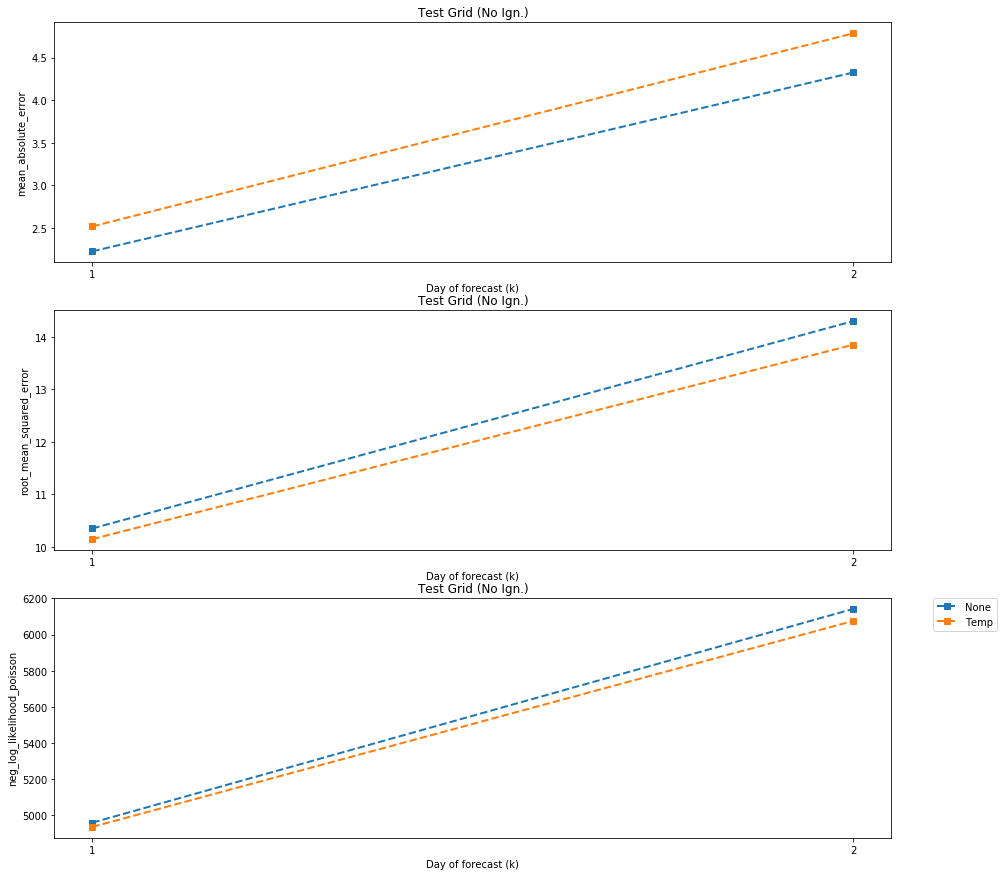

In [191]:
metrics_ = [metrics.mean_absolute_error, metrics.root_mean_squared_error, metrics.neg_log_likelihood_poisson]
vplt.plot_results_grid([(results_no_ig_grid[1], 'Test Grid (No Ign.)')], T_K_ARR, metrics_)

In [536]:
models_no_ig_grid['Temp'][0][0][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                  880
Model:                            GLM   Df Residuals:                      878
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1948.8
Date:                Fri, 02 Mar 2018   Deviance:                       165.19
Time:                        16:40:06   Pearson chi2:                     90.1
No. Iterations:                    34                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0335      0.031      1.084      0.278      -0.027       0.094
np.log(num_det + 1)     0.9006      0.061     14.811      0.000       0.781       1.020
temperature             0.0670      0.062      1.084      0.278      -0.054       0.188
=======================================================================================
"""

In [538]:
models_no_ig_grid['Temp'][1][0][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                  880
Model:                            GLM   Df Residuals:                      878
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2017.3
Date:                Fri, 02 Mar 2018   Deviance:                       312.59
Time:                        16:40:23   Pearson chi2:                     174.
No. Iterations:                    19                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1415      0.027      5.190      0.000       0.088       0.195
np.log(num_det + 1)     0.6870      0.054     12.774      0.000       0.582       0.792
temperature             0.2829      0.055      5.190      0.000       0.176       0.390
=======================================================================================
"""

In [457]:
from scipy import stats

In [459]:
-np.sum(stats.poisson.logpmf(220, 210), axis=None)

3.8505345336752725

In [66]:
out

defaultdict(<function visualization.plotting.recursive_defaultdict>,
            {'Poisson Grid (No Ign.)': defaultdict(<function visualization.plotting.recursive_defaultdict>,
                         {'None': defaultdict(<function visualization.plotting.recursive_defaultdict>,
                                      {'mean_absolute_error': ([1, 2, 3],
                                        [0.051165539694465315,
                                         0.064116203355872772,
                                         0.071377911344853495]),
                                       'neg_log_likelihood_poisson': ([1,
                                         2,
                                         3],
                                        [308321.64317854552,
                                         573827.80619264883,
                                         783410.51773035538]),
                                       'root_mean_squared_error': ([1, 2, 3],
                             

In [161]:
def plotter(outs, metric_, title):
    for out in outs:
        for model, d in out.iteritems():
            for cov, e in d.iteritems():       
                if cov=='All' or model =='Autoregressive Grid' or model=='Mean Grid':
                    for metric, f in e.iteritems():
                        if metric == metric_:
                            x,y = f
                            if model=='Median Grid': 
                                cov = 'None'
                            plt.plot(x, y, "s--",label=model+' '+cov, linewidth=2)
        plt.ylabel(metric_)
        plt.xlabel("Day of forecast (k)")
        plt.xticks(x)
        plt.title(title)
        plt.legend(loc=0)
                

In [ ]:
def plot_results_grid(results_list):
    #fig = plt.figure()
    f, axs = plt.subplots(len(metrics_), len(results_list), sharey='row')
    out = recursive_defaultdict()
    for j,(results,t) in enumerate(results_list):
        for i, metric in enumerate(metrics_):····
            ax = axs[i,j] if len(results_list) > 1 else axs[i]
            #ax = plt.subplot(len(metrics_),len(results_list),(i*len(results_list))+j+1)
            ax.set_title(t)
            for k,v in sorted(results.items()):·····
                x = range(1,len(results[k])+1)
                y = map(lambda x: metric(*flat(x)), results[k])
                ax.plot(x, y, "s--", label=k, linewidth=2)

                out[t][k][metric.__name__] = (x,y)
            ax.set_xlabel("Day of forecast (k)")
            ax.set_xticks(t_k_arr)
            if j == 0:
                ax.set_ylabel(metric.__name__)
            if i == 0:
                ax.legend(loc=0)
    return out

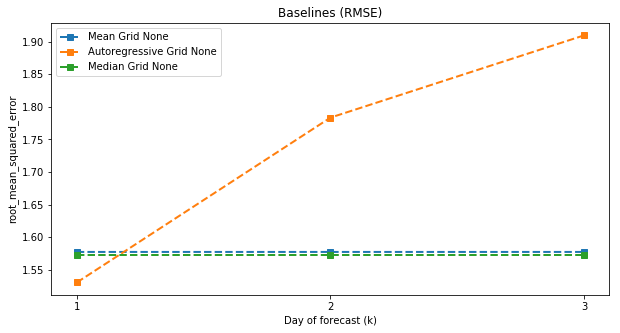

In [156]:
plt.rcParams['figure.figsize'] = [10, 5]
plotter([baselines,out], 'root_mean_squared_error', 'Baselines (RMSE)')

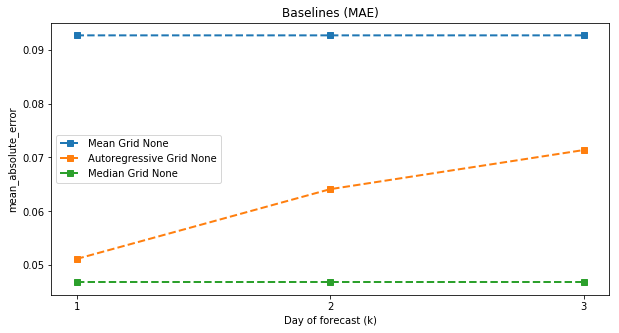

In [155]:
plotter([baselines,out], 'mean_absolute_error', 'Baselines (MAE)')

In [113]:
with open('combined-non-g_and_active-only-g_out.pkl', 'rb') as fin:
    comp = pickle.load(fin)

In [122]:
del comp['Poisson Non-Grid (No Ign.)']

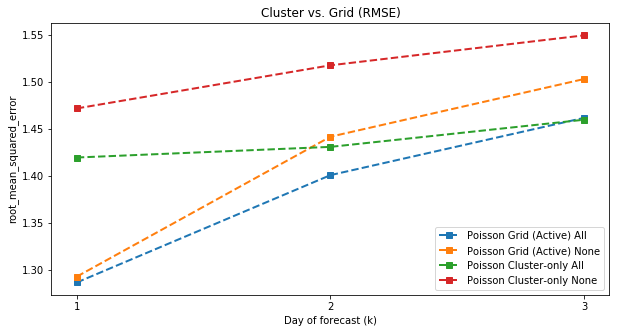

In [131]:
plotter(comp, 'root_mean_squared_error', 'Cluster vs. Grid (RMSE)')

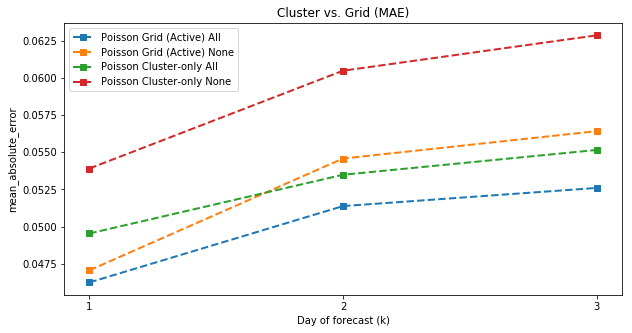

In [127]:
plotter(comp, 'mean_absolute_error', 'Cluster vs. Grid (MAE)')

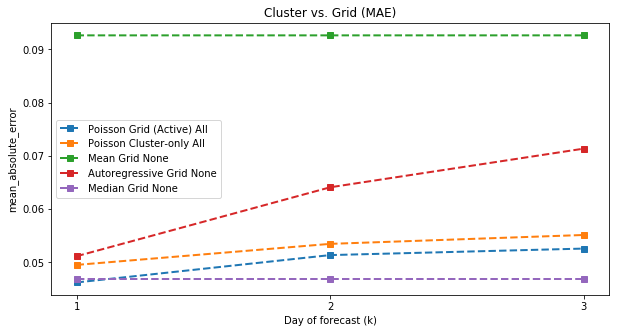

In [162]:
plotter([comp,baselines,out], 'mean_absolute_error', 'Cluster vs. Grid (MAE)')

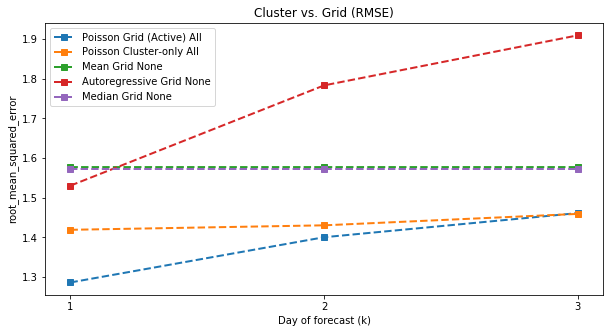

In [164]:
plotter([comp,baselines,out], 'root_mean_squared_error', 'Cluster vs. Grid (RMSE)')

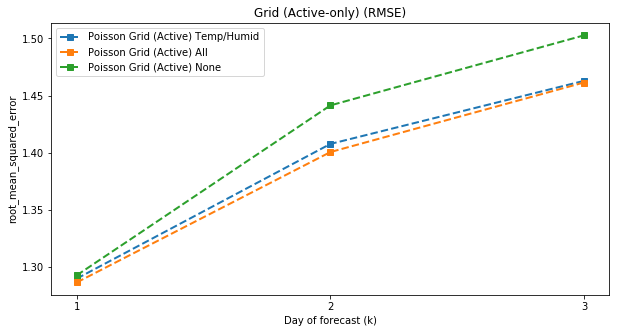

In [145]:
plotter([comp], 'root_mean_squared_error', 'Grid (Active-only) (RMSE)')

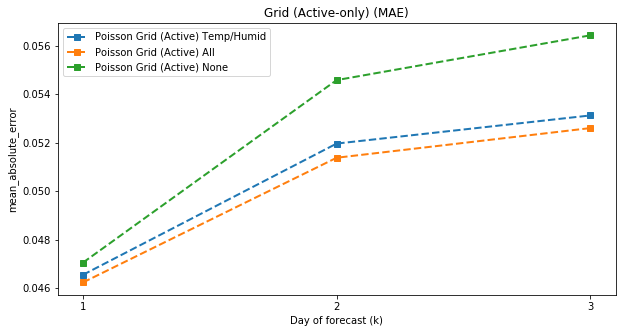

In [146]:
plotter([comp], 'mean_absolute_error', 'Grid (Active-only) (MAE)')